- **Note:** This repository is an implementation for [Less is More: Linear Layers on CLIP Features as Powerful VizWiz Model](https://arxiv.org/abs/2206.05281) paper.
- It is really advised to read OpenAI's [CLIP](https://openai.com/blog/clip/) paper before reading this repository if you have enough time.

# <a id='toc1_'></a>[Visual Question Answering](#toc0_)

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. VQA has many applications: Medical VQA, Education purposes, for surveillance and numerous other applications. In this project we will use [VizWiz](https://vizwiz.org/tasks-and-datasets/vqa/) dataset for Visual Question Answering, this dataset was constructed to train models to help visually impaired people.  In the words of creators of VizWiz: “we introduce the visual question answering (VQA) dataset coming from this population, which we call VizWiz-VQA.  It originates from a natural visual question answering setting where blind people each took an image and recorded a spoken question about it, together with 10 crowdsourced answers per visual question.”



<p align="center">
  <img src="Latex_Paper\graphics\chapter1\vizwiz_example.png" alt="vizwiz_example" width="500"/>
</p>

## <a id='toc1_1_'></a>[Installing Required Libraries](#toc0_)

In [7]:
!pip install -r requirements.txt


  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.3-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached wordcloud-1.9.4-cp310-cp310-win_amd64.whl.metadata (3.5 kB)
  Using cached pillow-11.3.0-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached scikit_learn-1.7.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached python_levenshtein-0.27.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached torch-2.8.0-cp310-cp310-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp310-cp310-win_amd64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.8.0-cp310-cp310-win_amd64.whl.metadata (7.2 kB)
  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
  Using cached sentencepiece-0.2.1-cp310-cp310-win_amd64.whl.metadata (10 kB)
  Using cached safetensors-0.6.2-cp38-abi3-wi

In [1]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np 
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json

from transformers import AutoModelForCausalLM, AutoTokenizer


e:\HK1  2025-2026\Đồ án CS420\VQA\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc1_3_'></a>[Configuring the Notebook](#toc0_)

In [14]:
# Configuring the paths for the dataset
INPUT_PATH = 'E:\HK1  2025-2026\Đồ án CS420\VQA\Dataset\VizWiz-'
ANNOTATIONS = INPUT_PATH + '/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
ANNOTATIONS_TEST_PATH = ANNOTATIONS + '/test.json'
TEST_PATH = INPUT_PATH + '/test/test'

OUTPUT_PATH = 'E:\HK1  2025-2026\Đồ án CS420\VQA\Output'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# Using accelerated computing if available
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

CUDA available: True
Device: cuda
GPU Name: NVIDIA GeForce RTX 3060


## <a id='toc1_4_'></a>[Processing Data](#toc0_)

In [15]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with available columns
    (image, question, answers, answer_type, answerable if exist)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the available columns
    """
    df = pd.read_json(path)

    cols = ['image', 'question', 'answers', 'answer_type', 'answerable']

    existing_cols = [c for c in cols if c in df.columns]
    df = df[existing_cols]

    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')
    
def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing
    
    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

## <a id='toc1_5_'></a>[Creating Dataframes & Splitting](#toc0_)

Ussing the defined function to create dataframes and split them into train and test cases.

In [16]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39512


## <a id='toc1_6_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc1_6_1_'></a>[Training Dataframe](#toc0_)

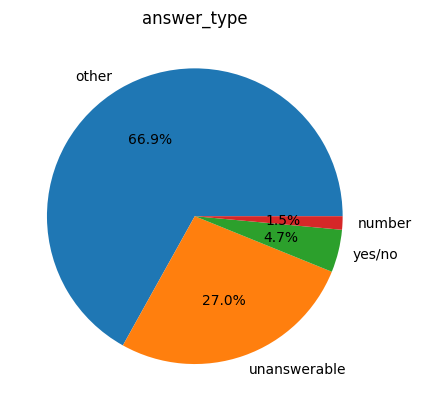

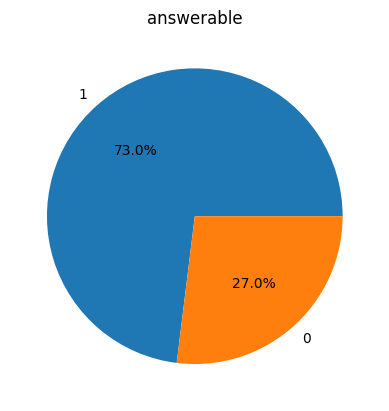

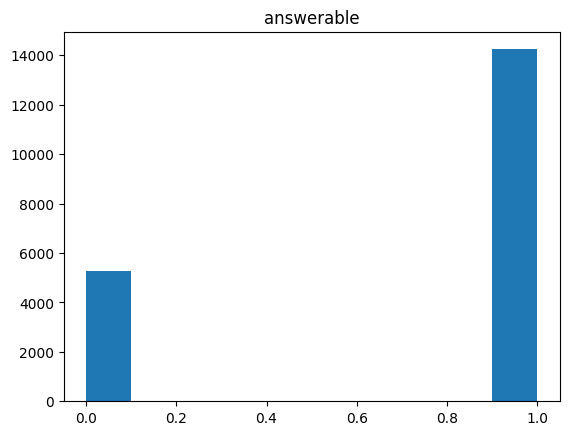

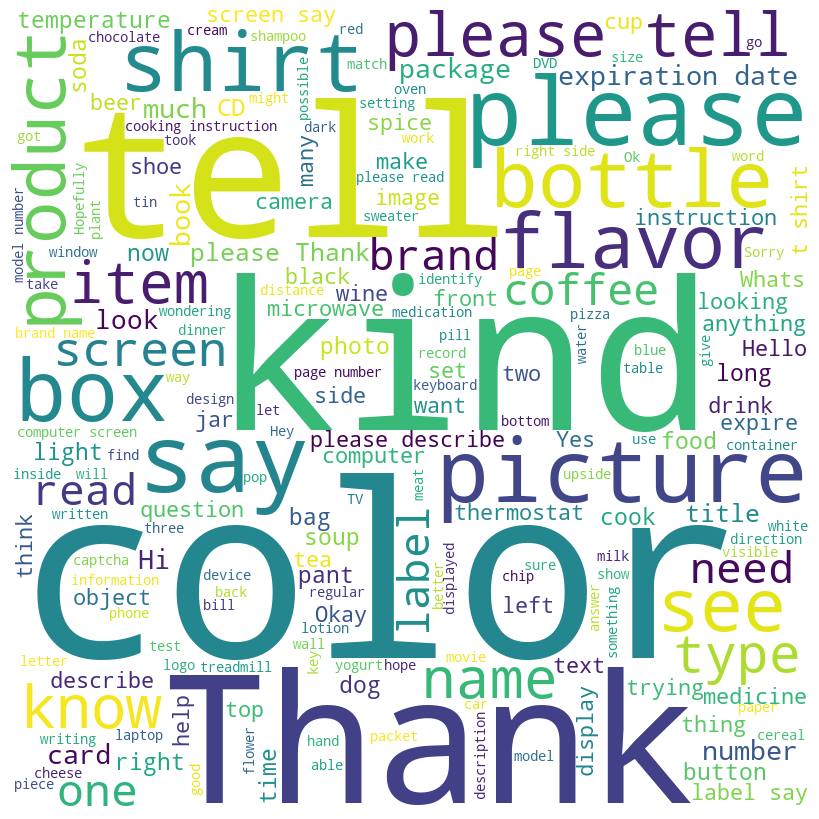

Number of distinct answers:  39512
Number of samples in train:  19496


In [6]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### <a id='toc1_6_2_'></a>[Validation Dataframe](#toc0_)

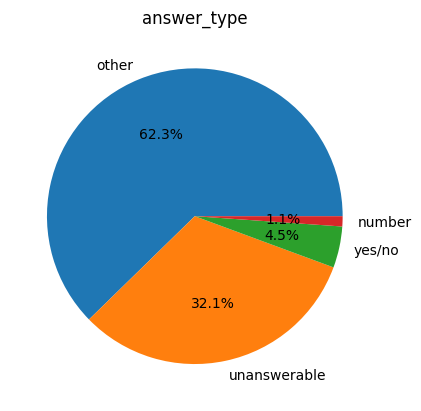

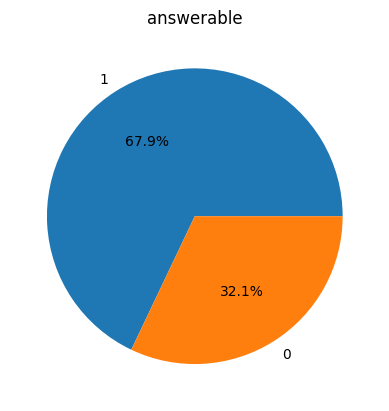

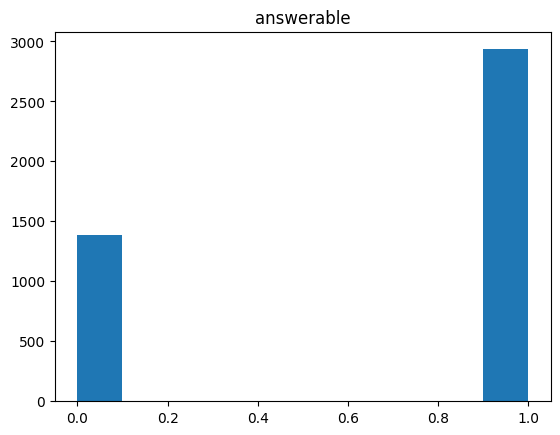

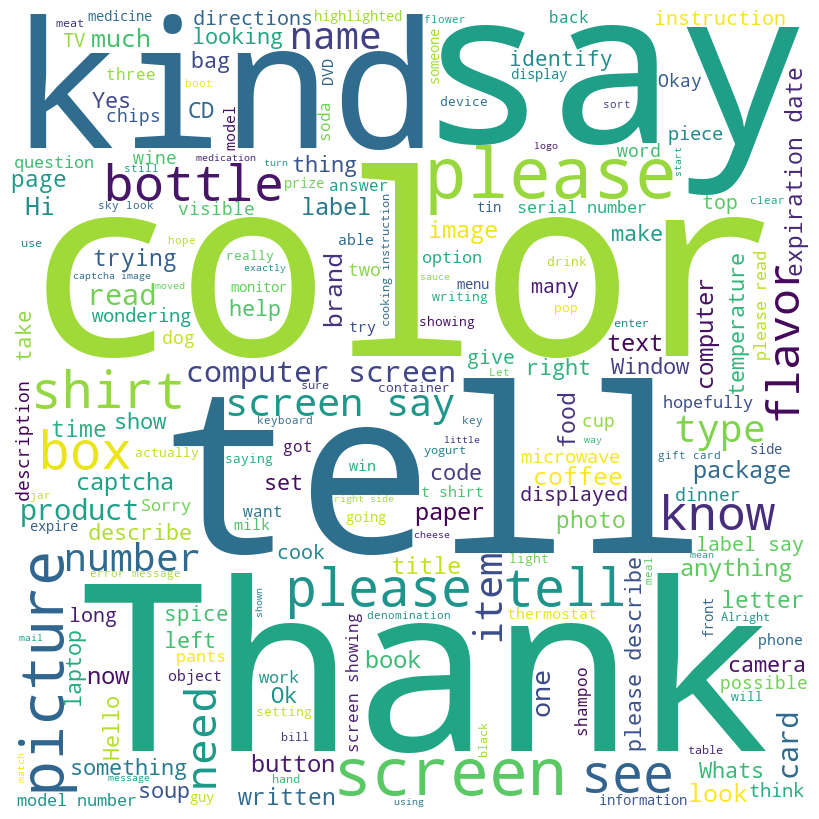

Number of distinct answers:  10903
Number of samples in validation set:  4319


In [6]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### <a id='toc1_6_3_'></a>[Testing Dataframe](#toc0_)

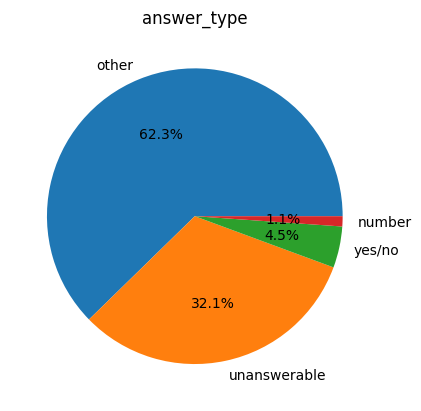

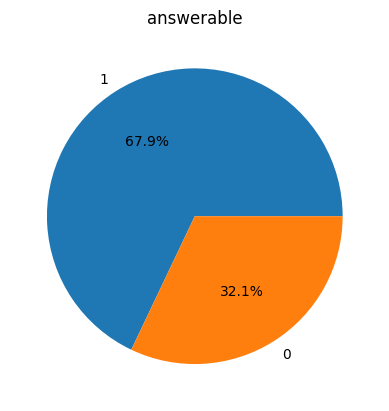

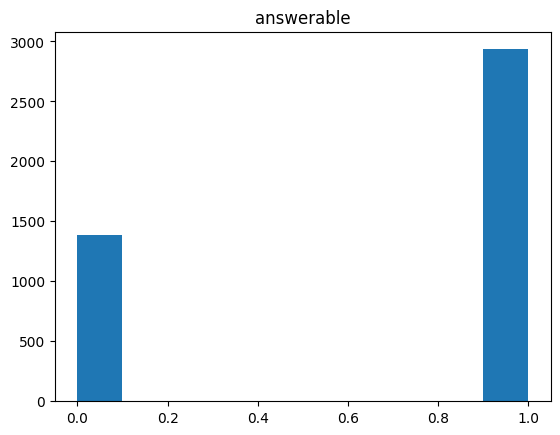

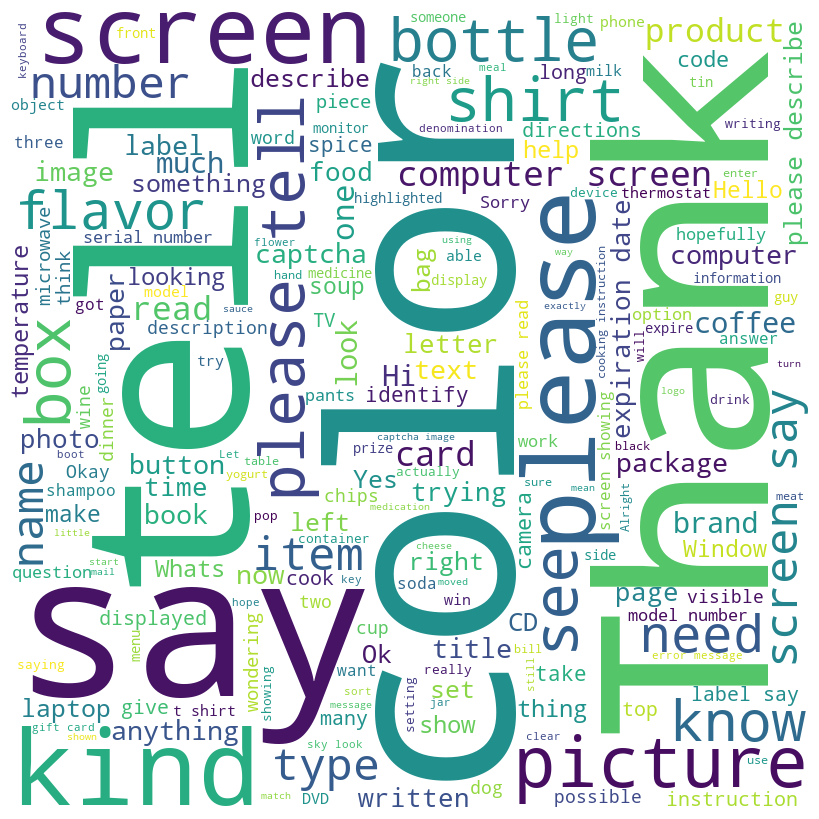

Number of distinct answers:  10903
Number of samples in validation set:  4319


In [7]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

## <a id='toc1_7_'></a>[Processing Images & Questions using CLIP model](#toc0_)

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically.

In [8]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:  
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

## <a id='toc1_8_'></a>[Creating Dataset Class](#toc0_)

In [17]:
import torch
from torch.utils.data import Dataset
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import Levenshtein as lev

class VizWizDataset(Dataset):
    def __init__(self, dataframe, 
                 answer_type_onehotencoder=None, 
                 answer_onehotencoder=None, 
                 model_name="RN50x64", 
                 images_features=torch.tensor([]), 
                 questions_features=torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Counter tổng số lần xuất hiện của tất cả answers (dùng để tie-breaking)
        self.answer_counter = Counter() 

        # Lưu embeddings ảnh & câu hỏi
        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()
        
        # Dataframe gốc
        self.dataframe = dataframe

        # Danh sách chỉ số answers cho mỗi câu hỏi (10 answers/question)
        self.answer_counter_per_question = []

        # Đếm tất cả answer trong dataset
        self.build_answer_counter()

        # Build vocab answer theo rule trong paper
        self.build_answer_vocab()

        # Số lượng distinct answers
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # Fit one-hot encoder cho answer_type nếu chưa có
        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])
        
        # Fit one-hot encoder cho answers nếu chưa có
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])
        
        # Lưu one-hot encoders
        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        # Encode answers & answer_type sang vector one-hot
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()
        
        # Danh mục answers (vocab)
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        # Thêm token <PAD> cho vocab (dùng khi thiếu câu trả lời)
        if "<PAD>" not in self.answers_categories:
            self.answers_categories.append("<PAD>")
        self.pad_idx = self.answers_categories.index("<PAD>")
        
        # Build counter per question
        self.build_answer_counter_per_question()
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return (self.images_features[index], 
                self.questions_features[index], 
                answer, answer_type, 
                answer_counter, 
                answerable)

    def build_answer_counter_per_question(self):
        """Tạo list 10 answer indices cho mỗi question"""
        for row in self.dataframe.itertuples(index=True):
            temp_list = []
            for answer_map in row.answers:
                ans = answer_map['answer']
                if ans in self.answers_categories:
                    ans_idx = self.answers_categories.index(ans)
                    temp_list.append(ans_idx)
            # pad nếu chưa đủ 10 answers
            while len(temp_list) < 10:
                temp_list.append(self.pad_idx)
            self.answer_counter_per_question.append(temp_list)

    def build_answer_vocab(self):
        """Chọn answer cho mỗi question theo rule trong paper"""
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)
        self.copied_dataframe['answer'] = None

        for row in self.dataframe.itertuples(index=True):
            intermediate_counter = Counter(ans['answer'] for ans in row.answers)

            # lấy answer phổ biến nhất trong 10 answers
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[row.Index, 'answer'] = top_elements[0][0]
            else:
                # tie → lấy answer phổ biến nhất trong toàn dataset
                global_top = self.answer_counter.most_common(1)
                if len(global_top) == 1:
                    self.copied_dataframe.at[row.Index, 'answer'] = global_top[0][0]
                else:
                    # tie nữa → chọn bằng levenshtein distance
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_dist = sum(
                            lev.distance(answer[0], other[0]) 
                            for other in top_elements if other != answer
                        )
                        if total_dist < current_min:
                            current_min = total_dist
                            current_answer = answer[0]
                    self.copied_dataframe.at[row.Index, 'answer'] = current_answer

    def build_answer_counter(self):
        """Đếm tất cả answers trong dataset"""
        self.answer_counter.update(
            ans['answer'] 
            for answers in self.dataframe['answers'] 
            for ans in answers
        )

    def get_answer_vocab(self):
        """Trả về vocab answer"""
        return self.copied_dataframe['answer'].unique()


## <a id='toc1_9_'></a>[Building Model's Architecture](#toc0_)

Now, let's build our model's architecture according to the paper. We will use PyTorch to build our model as we said before.

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, save_path="best_model.pth"):
        """
        Args:
            patience (int): số epoch chờ khi không cải thiện
            delta (float): cải thiện tối thiểu
            save_path (str): đường dẫn để lưu best model
        """
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss  # vì loss càng nhỏ càng tốt

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"⏳ EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        print(f"✅ Best model saved to {self.save_path}")

In [23]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.training_answerability = []
        self.validation_answerability = []
        
        self.device = device
        self.model_name = model_name
        
        # Initializing Binary Cross Entropy Loss which will be used to train the model on answerability
        self.answerability_loss_fn = nn.BCELoss()
        
        # Loading the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device = device)
        
        # Freezing the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes) 
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

        # Answerability Linear Layer (We removed drop out layer because training answerability was very bad)
        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Answerability Sigmoid Layer
        self.answerability_final_layer = nn.Linear(hidden_size, 1)

        # Sigmoid Layer for Answerability
        self.answerability_sigmoid = nn.Sigmoid()

    def forward(self, image, question):

        # Flattening and concatenating the image and question features
        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)
        
        # Calculating the answerability score
        answerability_score = self.answerability_linear_layer(features)
        answerability_score = self.answerability_final_layer(answerability_score)
        answerability_score = self.answerability_sigmoid(answerability_score)
        answerability_score = answerability_score.squeeze()
        
        # Passing the features through the first linear layer
        features = self.linear_layer1(features)

        # Passing the features to get 4 answer types
        answer_type = self.answer_type_layer(features)

        # Expanding answer make to the same size as the number of classes (vocab size)
        answer_mask = self.answer_mask_layer(answer_type)

        # Applying sigmoid to get the answer mask
        answer_mask = self.sigmoid(answer_mask)

        # Passing the features through the second linear layer
        output = self.linear_layer2(features)

        # Applying the answer mask to the output
        output = output * answer_mask
        
        return output, answer_type, answerability_score
    
    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy, train_answerability_score = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy, validation_answerability_score = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy, test_answerability_score = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)

            self.training_answerability.append(train_answerability_score)
            self.validation_answerability.append(validation_answerability_score)
            
            
            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))
            print("Epoch: {} | Training Answerability Score: {:.3f} | Validation Answerability Score: {:.3f} | Test Answerability Score: {:.3f}\n".format(epoch, train_answerability_score, validation_answerability_score, test_answerability_score))
            
            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
        return
    
    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)
            answerable = 1 - answerable
            answerable_predict = 1.0 - answerable_predict
            loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                answerable_true.append(answerable[i].item())
                answerable_predicted.append(answerable_predict[i].item())
        

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        return training_loss, training_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
            
    
    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)
                
                # Answerablity is the confidence that quesion is not answerable, so we have to subtract from 1
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
                    
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        # We will use weighted average since that there is imbalance in answerability in the dataset as displayed in EDA section
        return validation_loss, validation_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
    
    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
            
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def save_model(self, path):
        """
        Saves the model state dictionary to the given path.

        Args:
        - self: the model object
        - path (str): the path to save the model state dictionary

        Returns:
        - None
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Loads the model state dictionary from the given path.

        Args:
        - self: the model object
        - path (str): the path to load the model state dictionary

        Returns:
        - self: the loaded model object
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        """
        Predicts the output and answer type for the given image and question.

        Args:
        - self: the model object
        - image (tensor): the image tensor
        - question (tensor): the question tensor

        Returns:
        - output (tensor): the predicted output tensor
        - answer_type (str): the predicted answer type
        """
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        """
        Plots the training and validation losses.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        """
        Plots the VizWiz training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        """
        Plots the training and validation answerabilities.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_answerability, label = "Training Answerability")
        plt.plot(self.validation_answerability, label = "Validation Answerability")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        """
        Tests the model by predicting the answer and answer type for the given image and question.

        Args:
        - self: the model object
        - image_path (str): the path to the image file or URL
        - question (str): the question to be asked

        Returns:
        - predicted_answer (tensor): the predicted answer tensor
        - predicted_answer_type (str): the predicted answer type
        """
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        """
        Prints the details of the selected CLIP model.

        Args:
        - self: the model object

        Returns:
        - None
        """
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

## <a id='toc1_10_'></a>[Loading Preprocessed Embeddings](#toc0_)

In [20]:
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)

## <a id='toc1_11_'></a>[Preparing Data Loaders](#toc0_)

In [21]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5239
Number of distinct answers:  1468
Number of distinct answers:  469


## <a id='toc1_12_'></a>[Training the Model](#toc0_)

Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch: 1 | Training Loss: 6.571 | Validation Loss: 3.485
Epoch: 1 | Training Accuracy: 0.366 | Validation Accuracy: 0.568 | Test Accuracy: 0.488
Epoch: 1 | Training VizWiz Accuracy: 0.464 | Validation VizWiz Accuracy: 0.647 | Test VizWiz Accuracy: 0.587
Epoch: 1 | Training Answerability Score: 0.701 | Validation Answerability Score: 0.806 | Test Answerability Score: 0.793

Epoch: 2 | Training Loss: 5.896 | Validation Loss: 3.154
Epoch: 2 | Training Accuracy: 0.385 | Validation Accuracy: 0.579 | Test Accuracy: 0.503
Epoch: 2 | Training VizWiz Accuracy: 0.480 | Validation VizWiz Accuracy: 0.663 | Test VizWiz Accuracy: 0.597
Epoch: 2 | Training Answerability Score: 0.750 | Validation Answerability Score: 0.810 | Test Answerability Score: 0.794

Epoch: 3 | Training Loss: 5.345 | Validation Loss: 2.883
Epoch: 3 | Training Accuracy: 0.408 | Validation Accuracy: 0.609 | Tes

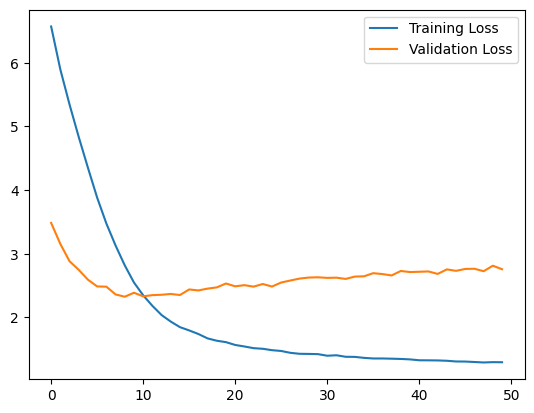

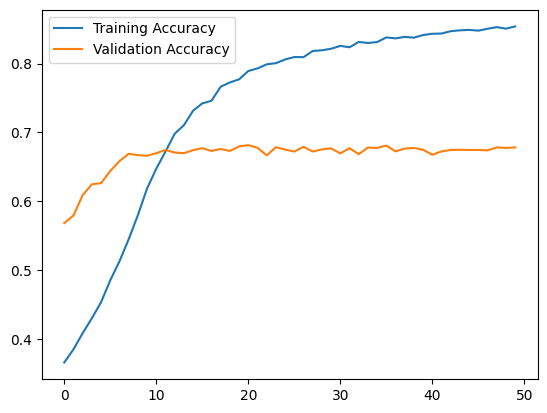

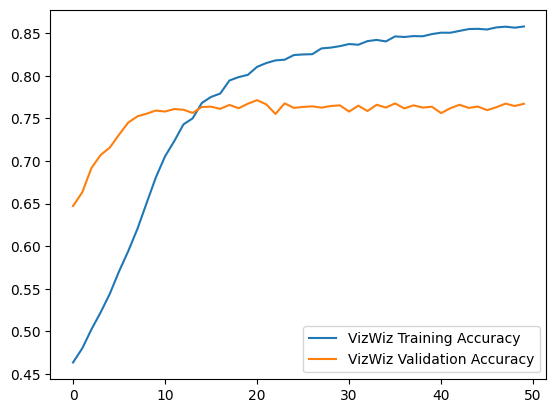

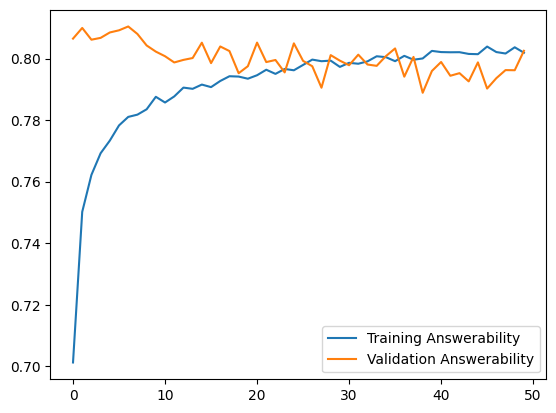

In [14]:
# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 5

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()

## <a id='toc1_14_'></a>[Test your own image !](#toc0_)

The following part of code allows the user to test his own image using the trained model. You just have to configure `IMAGE_PATH` and `QUESTION` variables and run the cell.

In [16]:
# Taking a sample image and question from the user
QUESTION = "Is this a book?"
IMAGE_PATH = r"E:\HK1  2025-2026\Đồ án CS420\VQA\Dataset\VizWiz-\test\test\VizWiz_test_00007930.jpg"

# Loading the fitted One Hot Encoders from the disk
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

# Loading the model from the disk
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
NUM_CLASSES = len(training_dataset.get_answer_vocab())
MODEL_PATH = "E:\HK1  2025-2026\Đồ án CS420\VQA\Outputepoch_40.pth" # OUTPUT_PATH + 'model.pt'
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.load_model(MODEL_PATH)

# Predicting the answer and answer type
predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = IMAGE_PATH, question = QUESTION)
answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())

# Printing the answer and answer type
print("The Answer is: " + answer[0][0])
print("The Answer Type is: " + answer_type[0][0])
print("The confidence for being unanswerable: " + str(answerability.item()))

The Answer is: no
The Answer Type is: yes/no
The confidence for being unanswerable: 0.03406006097793579


## <a id='toc1_15_'></a>[Building Test Answers](#toc0_)

In [26]:
df = pd.read_json("E:/HK1  2025-2026/Đồ án CS420/VQA/Dataset/VizWiz-/Annotations/test.json")
df = df[['image', 'question']]

# let's create two json objects to store the output of the model then write them to a file
model_answers = []
model_answerability = []

for i in range(len(df)):
    image_url = df['image'][i]
    question = df['question'][i]
    image_path = os.path.join(TEST_PATH, image_url)

    predicted_answer, predicted_answer_type, answerability = model.test_model(
        image_path=image_path,
        question=question
    )

    answer = ANSWER_ONEHOTENCODER.inverse_transform(
        predicted_answer.cpu().detach().numpy()
    )
    answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(
        predicted_answer_type.cpu().detach().numpy()
    )

    answer_result = {
        'image': image_url,
        'answer': answer[0][0]
    }
    answerability_result = {
        'image': image_url,
        'answerable': float(answerability.item())  # đổi tên key + cast float
    }

    model_answers.append(answer_result)
    model_answerability.append(answerability_result)

# Wrap lại theo format yêu cầu
with open('answers_results1.json', 'w', encoding='utf-8') as f:
    json.dump({"results": model_answers}, f, indent=4, ensure_ascii=False)

with open('answerability_results1.json', 'w', encoding='utf-8') as f:
    json.dump({"results": model_answerability}, f, indent=4, ensure_ascii=False)


## <a id='toc1_16_'></a>[CLIP + Phi-3-mini](#toc0_)

Ảnh --> CLIP ViT-L/14 --> Image embedding --> Linear Projection --> Vicuna input --> Trả lời


In [4]:

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    CLIP_MODEL_NAME = "ViT-L/14@336px"
    PHI3_MODEL = "microsoft/Phi-3-mini-4k-instruct"  # model mới của Microsoft
    CHECKPOINT_PATH = "Outputepoch_45.pth"

    # ================== LOAD CLIP ==================
    clip_model, preprocess = clip.load(CLIP_MODEL_NAME, device=DEVICE)
    clip_model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [5]:

# Load fine-tuned CLIP checkpoint nếu có
checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
clip_state_dict = {k.replace("clip_model.", ""): v for k, v in checkpoint.items() if "clip_model." in k}
missing, unexpected = clip_model.load_state_dict(clip_state_dict, strict=False)
print("✅ Loaded fine-tuned CLIP weights.")
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21484\2534261193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE

✅ Loaded fine-tuned CLIP weights.
Missing keys: []
Unexpected keys: []


In [6]:

print("🔄 Loading Phi-3 model... (This may take a minute)")
tokenizer = AutoTokenizer.from_pretrained(PHI3_MODEL)

phi3 = AutoModelForCausalLM.from_pretrained(
    PHI3_MODEL,
    torch_dtype=torch.float16,
    device_map="auto",
)
phi3.eval()
print("✅ Loaded Phi-3 model successfully.")


🔄 Loading Phi-3 model... (This may take a minute)


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]


✅ Loaded Phi-3 model successfully.


In [25]:
def get_text_embeds(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True).to(DEVICE)
    input_ids = inputs["input_ids"]
    attn = inputs["attention_mask"]
    # prefer get_input_embeddings to be robust
    text_embeds = phi3.get_input_embeddings()(input_ids).to(torch.float16)
    return text_embeds, attn

In [7]:
clip_embed_dim = 768  # ViT-L/14 output dim
llm_embed_dim = phi3.config.hidden_size  # Phi-3 hidden size (3072)
projection = nn.Linear(clip_embed_dim, llm_embed_dim).to(DEVICE).to(torch.float16)

In [31]:
def generate_answer(image_path, question, max_new_tokens=264):
    # image
    pil = Image.open(image_path).convert("RGB")
    img_t = preprocess(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_t).to(torch.float16)  # [1, C]
        img_proj = projection(img_feat)                              # [1, hidden]
        img_proj = img_proj.unsqueeze(1)                             # [1,1,hidden]

        prompt = f"Question: {question}\nAnswer:"
        text_embeds, attn = get_text_embeds(prompt)                  # [1, L, hidden], [1, L]

        # concatenation
        full_embeds = torch.cat([img_proj, text_embeds], dim=1)      # [1, 1+L, hidden]

        # build extended attention mask: 1 for image token + existing mask
        ext_mask = torch.cat([torch.ones((1,1), device=DEVICE, dtype=attn.dtype), attn], dim=1)

        outputs = phi3.generate(
            inputs_embeds=full_embeds,
            attention_mask=ext_mask,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [32]:
answer = generate_answer("Dataset/VizWiz-/train/train/VizWiz_train_00000020.jpg", "What is this game?")
print(" Model Answer:", answer)

 Model Answer: This game is called "The Legend of Zelda: Breath of the Wild." It's an action-adventure game developed and published by Nintendo for the Nintendo Switch, Wii U, and 3DS. The game was released on March 3, 2017, in Japan, North America, and Europe. It's the sequel to "The Legend of Zelda: A Link Between Worlds" and is the 19th installment in the main series. In "Breath of the Wild," players take on the role of Link, who awakens from a 100-year slumber to find the kingdom of Hyrule in ruins. With the help of new allies and a mysterious girl named Sheikah, Link must explore the vast open world, complete quests, and uncover the truth behind the fall of Hyrule.

The game features a dynamic weather system, destructible environments, and a physics-based combat system. Link can use a variety of weapons, including swords, bows, and a shield, to defeat enemies and solve puzzles. The game also includes a crafting system, allowing players to create and upgrade weapons, armor, and ite